In [3]:
# Import all necessary packages
import pandas as pd
import numpy as np

# Plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.style.use('ggplot')

### London areas and coordinates

In [4]:
# Import London postcode districts
london = pd.read_html('https://en.wikipedia.org/wiki/List_of_areas_of_London')[1]

# For some reason the imported column names seem to give many problems, therefore the columns are renamed
london.columns = ['Area', 'Borough', 'Post town', 'Postcode district', 'Dial code', 'OS grid ref']

# Unnecessary columns are dropped
london.drop(['Postcode district', 'Dial code', 'OS grid ref'], axis=1, inplace=True)

# Clean up the "London borough" column by deleting the references
for ref in range(44): #there are 43 references in the dataset
    london['Borough'].replace({"\["+str(ref)+"\]": ""}, regex=True, inplace=True)
    
# Assign areas in multiple boroughs to first mentioned borough
london['Borough'] = london['Borough'].str.split(', ').str[0]
london['Borough'] = london['Borough'].str.split(' & ').str[0]

# Assign areas with multiple names to first mentioned name
london['Area'] = london['Area'].str.split('\(also ').str[0]

In [5]:
# Check if all the areas belong to a certain borough now
london.groupby(['Borough']).count().sort_values(['Area'], ascending=True).head(10)

Area  Post town
Borough                                                      
Kensington and ChelseaHammersmith and Fulham     1          1
Camden and Islington                             1          1
Haringey and Barnet                              1          1
Dartford                                         1          1
City                                             4          4
Sutton                                           7          7
Barking and Dagenham                             8          8
Waltham Forest                                   8          8
Kensington and Chelsea                           8          8
Hammersmith and Fulham                           9          9

In [6]:
# Remove the boroughs with only one area since they are combinations of multiple boroughs or outliers
london = london[london.groupby('Borough')['Borough'].transform('count').ge(2)]
london.reset_index(drop=True, inplace=True)

london.groupby(['Borough']).count().sort_values(['Area'], ascending=True).head(10)

Area  Post town
Borough                                
City                       4          4
Sutton                     7          7
Barking and Dagenham       8          8
Waltham Forest             8          8
Kensington and Chelsea     8          8
Hammersmith and Fulham     9          9
Wandsworth                10         10
Merton                    10         10
Ealing                    10         10
Lambeth                   12         12

In [7]:
# Keep list of all boroughs for later
london_all_boroughs = london['Borough'].unique()

In [8]:
# Only keep the areas that are in the "LONDON" post town
london.drop(london[london['Post town']!="LONDON"].index, inplace=True)

In [9]:
london.head(15)

Area               Borough Post town
0    Abbey Wood                Bexley    LONDON
1         Acton                Ealing    LONDON
6       Aldgate                  City    LONDON
7       Aldwych           Westminster    LONDON
9       Anerley               Bromley    LONDON
10        Angel             Islington    LONDON
12      Archway             Islington    LONDON
15  Arnos Grove               Enfield    LONDON
16       Balham            Wandsworth    LONDON
17     Bankside             Southwark    LONDON
18     Barbican                  City    LONDON
22       Barnes  Richmond upon Thames    LONDON
26    Barnsbury             Islington    LONDON
27    Battersea            Wandsworth    LONDON
28    Bayswater           Westminster    LONDON

In [10]:
from geopy.geocoders import Nominatim

# Use Nominatim to retrieve area data 
geolocator = Nominatim(user_agent="lon_explorer")

lat = []
lon = []

# For all listed areas, find the coordinates and append them to the lat and long lists
for area, borough in zip(london['Area'], london['Borough']):
    print(area)
    try:
        address = '{}, {}, London, United Kingdom'.format(area, borough)
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        lon.append(longitude)
    except: # if no coordinates are found, return NaNs
        lat.append(np.nan)
        lon.append(np.nan)
        
print("Coordinates retrieved!")

Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Bromley 
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Church End
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Custom House
Dalston
De Beauvoir Town
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham
East Sheen
Edmonton
Elephant and Castle
Eltham
Farringdon
Finchley
Finsbury
Finsbury Park
Fitzrovia
Fo

In [11]:
# Add the coordinates to the london dataframe
london['Latitude'] = lat
london['Longitude'] = lon

# Drop the areas without coordinates and reset the index
london.dropna(axis=0, inplace=True)
london.reset_index(drop=True, inplace=True)

In [12]:
# Drop the unnecessary 'Post town column'
london.drop('Post town', axis=1, inplace=True)
london.reset_index(drop=True, inplace=True)

In [13]:
london.head(10)

Area      Borough   Latitude  Longitude
0   Abbey Wood       Bexley  51.491060   0.121216
1        Acton       Ealing  51.508140  -0.273261
2      Aldgate         City  51.514248  -0.075719
3      Aldwych  Westminster  51.513103  -0.114920
4      Anerley      Bromley  51.407599  -0.061939
5        Angel    Islington  51.531946  -0.106106
6      Archway    Islington  51.565437  -0.134998
7  Arnos Grove      Enfield  51.616402  -0.133287
8       Balham   Wandsworth  51.445645  -0.150364
9     Bankside    Southwark  51.508302  -0.096297

In [14]:
# Save it to CSV for future processing
london.to_csv('london_areas.csv')

In [15]:
#london = pd.read_csv('london_areas.csv')

In [16]:
import folium

In [17]:
# Find coordinates of London
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="lon_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Make map of London with all areas superimposed on top
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(london['Latitude'], london['Longitude'], london['Borough'], london['Area']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

map_london

### Most gentrified boroughs

In [18]:
# Create list of notoriously gentrified boroughs according to:
# https://londonist.com/london/news/these-are-london-s-most-gentrified-boroughs-but-are-they-really

gent_boroughs = ['Kensington and Chelsea', 'Richmond upon Thames', 'Westminster', 'Hammersmith and Fulham', 'Merton']

gent_boroughs

['Kensington and Chelsea',
 'Richmond upon Thames',
 'Westminster',
 'Hammersmith and Fulham',
 'Merton']

In [19]:
# Only use the boroughs that are in the London post town
gent_boroughs_london = list(set(london['Borough'].unique()).intersection(gent_boroughs))
print(gent_boroughs_london)

['Merton', 'Kensington and Chelsea', 'Westminster', 'Richmond upon Thames', 'Hammersmith and Fulham']


In [20]:
ungent_boroughs_london = list(set(london['Borough'].unique()).difference(gent_boroughs_london))
print(ungent_boroughs_london)

['Croydon', 'Brent', 'Hounslow', 'City', 'Camden', 'Haringey', 'Kingston upon Thames', 'Waltham Forest', 'Ealing', 'Greenwich', 'Enfield', 'Hackney', 'Southwark', 'Redbridge', 'Wandsworth', 'Newham', 'Bexley', 'Bromley', 'Islington', 'Barnet', 'Tower Hamlets', 'Lambeth', 'Lewisham']


In [21]:
# Make a dataframe of only the areas in gentrified boroughs
london_gent = london.loc[london['Borough'].isin(gent_boroughs_london)].reset_index(drop=True)
london_gent.head()

Area               Borough   Latitude  Longitude
0    Aldwych           Westminster  51.513103  -0.114920
1     Barnes  Richmond upon Thames  51.471896  -0.238744
2  Bayswater           Westminster  51.512276  -0.188385
3  Belgravia           Westminster  51.498213  -0.153500
4  Castelnau  Richmond upon Thames  51.487429  -0.231228

In [22]:
# Make a dataframe of only the areas in ungentrified boroughs
london_ungent = london.loc[london['Borough'].isin(ungent_boroughs_london)].reset_index(drop=True)
london_ungent.head()

Area    Borough   Latitude  Longitude
0  Abbey Wood     Bexley  51.491060   0.121216
1       Acton     Ealing  51.508140  -0.273261
2     Aldgate       City  51.514248  -0.075719
3     Anerley    Bromley  51.407599  -0.061939
4       Angel  Islington  51.531946  -0.106106

In [23]:
import requests
import copy

In [24]:
# Download the .geojson file with London's boroughs
london_json_url = 'https://skgrange.github.io/www/data/london_boroughs.json'
london_json = requests.get(london_json_url).json()

In [25]:
# Create a list of all the boroughs that are not in London
not_in_london = list(set(london_all_boroughs).difference(set(london['Borough'].unique())))

In [26]:
# Create the difference lists of boroughs that need to be dropped to create different .jsons
to_drop_gent = not_in_london + ungent_boroughs_london
to_drop_ungent = not_in_london + gent_boroughs_london

In [27]:
# Change the name of City of London to "City" as in all the other dataframes
for i in range(len(london_json['features'])):            
    if london_json['features'][i]['properties']['name'] == "City of London":
        london_json['features'][i]['properties']['name'] = "City"

# Create the new jsons for the gentrified and ungentrified boroughs
london_json_gent = copy.deepcopy(london_json)
london_json_ungent = copy.deepcopy(london_json)

for borough in to_drop_gent:
    length = len(london_json_gent['features'])
    for i in range(length):
        i -= 1
        if london_json_gent['features'][i]['properties']['name'] == borough:
            del london_json_gent['features'][i]

for borough in to_drop_ungent:
    length = len(london_json_ungent['features'])
    for i in range(length):
        i -= 1
        if london_json_ungent['features'][i]['properties']['name'] == borough:
            del london_json_ungent['features'][i]

In [29]:
def boroughs_gent_style(feature):
    return { 'color': 'red', 'fill': True }

def boroughs_ungent_style(feature):
    return { 'color': 'green', 'fill': True }

In [30]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.GeoJson(london_json_gent, name='geojson', style_function=boroughs_gent_style).add_to(map_london)
folium.GeoJson(london_json_ungent, name='geojson', style_function=boroughs_ungent_style).add_to(map_london)
map_london

### Foursquare API

In [31]:
# Foursquare API credentials
CLIENT_ID = "IMJYBRUN14HSL2VZYUJ0ZO5V1LLRNIEWWQREUJLOEATESNDF"
CLIENT_SECRET = "TGNXBBYTREXNXOX3YT0RQLENFFLYCBTUSIVPN2KJ1MA25UGJ"
VERSION = '20180605'

In [32]:
# Find first 100 venues in 250 meter radius
LIMIT = 100
radius = 250

In [33]:
# Function to retrieve nearby venues from Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name) # in order to keep process of how far along we are
        
        # API request URL is created, calling upon global variables defined before
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # Make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Filter the relevant information
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    # Store in dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                'Area Latitude', 
                'Area Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
    
    return(nearby_venues)

In [34]:
london_venues = getNearbyVenues(names=london['Area'],
                                 latitudes=london['Latitude'],
                                 longitudes=london['Longitude']
                                )

print("\nFinished.")

Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Bromley 
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Church End
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Dalston
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham
East Sheen
Edmonton
Elephant and Castle
Eltham
Farringdon
Finchley
Finsbury
Finsbury Park
Fitzrovia
Forest Gate
Forest Hill
Fortis Green
Frier

In [35]:
# Show the new dataframe with all the venues
london_venues.head(10)

Area  Area Latitude  Area Longitude  \
0  Abbey Wood       51.49106        0.121216   
1  Abbey Wood       51.49106        0.121216   
2  Abbey Wood       51.49106        0.121216   
3  Abbey Wood       51.49106        0.121216   
4  Abbey Wood       51.49106        0.121216   
5  Abbey Wood       51.49106        0.121216   
6       Acton       51.50814       -0.273261   
7       Acton       51.50814       -0.273261   
8       Acton       51.50814       -0.273261   
9       Acton       51.50814       -0.273261   

                                  Venue  Venue Latitude  Venue Longitude  \
0                           Sainsbury's       51.492824         0.120724   
1      Abbey Wood Railway Station (ABW)       51.490825         0.123432   
2                        The Abbey Arms       51.490693         0.121182   
3                            Platform 1       51.491023         0.119491   
4                            Costcutter       51.491287         0.120938   
5                           Bean @ Work       51.491172         0.120649   
6                     London Star Hotel       51.509624        -0.272456   
7  Dragonfly Brewery at George & Dragon       51.507378        -0.271702   
8                          The Aeronaut       51.508376        -0.275216   
9                     Amigo's Peri Peri       51.508396        -0.274561   

         Venue Category  
0           Supermarket  
1         Train Station  
2                   Pub  
3              Platform  
4     Convenience Store  
5           Coffee Shop  
6                 Hotel  
7               Brewery  
8                   Pub  
9  Fast Food Restaurant

In [36]:
# Save it to CSV for future processing
london_venues.to_csv("london_venues.csv")

In [37]:
#london_venues = pd.read_csv("london_venues.csv")

In [38]:
# Add the boroughs to the list of venues
london_merged = london.join(london_venues.set_index('Area'), on='Area')
london_merged.reset_index(drop=True, inplace=True)
london_merged.head(10)

Area Borough  Latitude  Longitude  Area Latitude  Area Longitude  \
0  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
1  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
2  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
3  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
4  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
5  Abbey Wood  Bexley  51.49106   0.121216       51.49106        0.121216   
6       Acton  Ealing  51.50814  -0.273261       51.50814       -0.273261   
7       Acton  Ealing  51.50814  -0.273261       51.50814       -0.273261   
8       Acton  Ealing  51.50814  -0.273261       51.50814       -0.273261   
9       Acton  Ealing  51.50814  -0.273261       51.50814       -0.273261   

                                  Venue  Venue Latitude  Venue Longitude  \
0                           Sainsbury's       51.492824         0.120724   
1      Abbey Wood Railway Station (ABW)       51.490825         0.123432   
2                        The Abbey Arms       51.490693         0.121182   
3                            Platform 1       51.491023         0.119491   
4                            Costcutter       51.491287         0.120938   
5                           Bean @ Work       51.491172         0.120649   
6                     London Star Hotel       51.509624        -0.272456   
7  Dragonfly Brewery at George & Dragon       51.507378        -0.271702   
8                          The Aeronaut       51.508376        -0.275216   
9                     Amigo's Peri Peri       51.508396        -0.274561   

         Venue Category  
0           Supermarket  
1         Train Station  
2                   Pub  
3              Platform  
4     Convenience Store  
5           Coffee Shop  
6                 Hotel  
7               Brewery  
8                   Pub  
9  Fast Food Restaurant

In [39]:
# Make dataframe with only venues in gentrified areas
london_venues_gent = london_merged.loc[london_merged['Borough'].isin(gent_boroughs_london)].reset_index(drop=True)
london_venues_gent.shape

(1061, 10)

In [40]:
# Make dataframe with only venues in ungentrified areas
london_venues_ungent = london_merged.loc[london_merged['Borough'].isin(ungent_boroughs_london)].reset_index(drop=True)
london_venues_ungent.shape

(3191, 10)

### Analyze venues in gentrified areas

In [41]:
gent_venues_frequency = london_venues_gent.groupby('Venue Category').count().sort_values(by='Area', ascending=False).head(15)
gent_venues_frequency

Area  Borough  Latitude  Longitude  Area Latitude  \
Venue Category                                                          
Coffee Shop           68       68        68         68             68   
Pub                   55       55        55         55             55   
Café                  49       49        49         49             49   
Hotel                 45       45        45         45             45   
Grocery Store         31       31        31         31             31   
Italian Restaurant    30       30        30         30             30   
Bakery                28       28        28         28             28   
Theater               25       25        25         25             25   
Restaurant            22       22        22         22             22   
Burger Joint          19       19        19         19             19   
Chinese Restaurant    18       18        18         18             18   
Sandwich Place        18       18        18         18             18   
Thai Restaurant       18       18        18         18             18   
Pizza Place           17       17        17         17             17   
Park                  16       16        16         16             16   

                    Area Longitude  Venue  Venue Latitude  Venue Longitude  
Venue Category                                                              
Coffee Shop                     68     68              68               68  
Pub                             55     55              55               55  
Café                            49     49              49               49  
Hotel                           45     45              45               45  
Grocery Store                   31     31              31               31  
Italian Restaurant              30     30              30               30  
Bakery                          28     28              28               28  
Theater                         25     25              25               25  
Restaurant                      22     22              22               22  
Burger Joint                    19     19              19               19  
Chinese Restaurant              18     18              18               18  
Sandwich Place                  18     18              18               18  
Thai Restaurant                 18     18              18               18  
Pizza Place                     17     17              17               17  
Park                            16     16              16               16

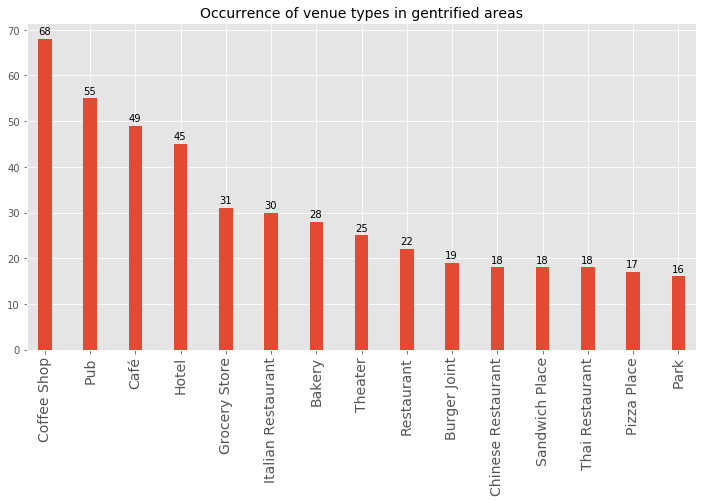

In [42]:
ax = gent_venues_frequency['Area'].plot(kind='bar', width=0.3, figsize=(12, 6))

ax.set_title('Occurrence of venue types in gentrified areas', size=14)
ax.set_xticklabels(gent_venues_frequency.index, size=14)
ax.set_xlabel("")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 1), )

plt.show()

In [43]:
# Show the amount of venues per area
london_venues.groupby('Area').count().sort_values('Venue', ascending=False)

Area Latitude  Area Longitude  Venue  Venue Latitude  \
Area                                                                    
Chinatown                   81              81     81              81   
Soho                        80              80     80              80   
Wimbledon                   70              70     70              70   
Covent Garden               67              67     67              67   
Shoreditch                  61              61     61              61   
...                        ...             ...    ...             ...   
West Heath                   1               1      1               1   
Old Oak Common               1               1      1               1   
Rotherhithe                  1               1      1               1   
Shooter's Hill               1               1      1               1   
Wormwood Scrubs              1               1      1               1   

                 Venue Longitude  Venue Category  
Area                                              
Chinatown                     81              81  
Soho                          80              80  
Wimbledon                     70              70  
Covent Garden                 67              67  
Shoreditch                    61              61  
...                          ...             ...  
West Heath                     1               1  
Old Oak Common                 1               1  
Rotherhithe                    1               1  
Shooter's Hill                 1               1  
Wormwood Scrubs                1               1  

[277 rows x 6 columns]

In [44]:
# Drop all areas with less than 15 venues, since they will be difficult to compare.
london_venues_filtered = london_venues[london_venues.groupby('Area')['Area'].transform('count').ge(15)]
london_venues_filtered.reset_index(drop=True, inplace=True)

london_venues_filtered.groupby('Area').count()

Area Latitude  Area Longitude  Venue  Venue Latitude  \
Area                                                                
Aldgate                 36              36     36              36   
Aldwych                 32              32     32              32   
Angel                   43              43     43              43   
Archway                 26              26     26              26   
Balham                  37              37     37              37   
...                    ...             ...    ...             ...   
Westminster             23              23     23              23   
Whetstone               17              17     17              17   
White City              15              15     15              15   
Wimbledon               70              70     70              70   
Wood Green              21              21     21              21   

             Venue Longitude  Venue Category  
Area                                          
Aldgate                   36              36  
Aldwych                   32              32  
Angel                     43              43  
Archway                   26              26  
Balham                    37              37  
...                      ...             ...  
Westminster               23              23  
Whetstone                 17              17  
White City                15              15  
Wimbledon                 70              70  
Wood Green                21              21  

[107 rows x 6 columns]

In [45]:
london_onehot = pd.get_dummies(london_merged[['Venue Category']], prefix="", prefix_sep="")

# Add the neighborhood column back to dataframe
london_onehot['Area'] = london_merged['Area'] 

# Move the neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

# Check the mean occurence to see which venue category has the biggest frequency per neighborhood
london_grouped = london_onehot.groupby('Area').mean().reset_index()
london_grouped.head(10)

Area  African Restaurant  American Restaurant  Antique Shop  \
0   Abbey Wood                 0.0             0.000000           0.0   
1        Acton                 0.0             0.000000           0.0   
2      Aldgate                 0.0             0.027778           0.0   
3      Aldwych                 0.0             0.000000           0.0   
4      Anerley                 0.0             0.000000           0.0   
5        Angel                 0.0             0.000000           0.0   
6      Archway                 0.0             0.000000           0.0   
7  Arnos Grove                 0.0             0.000000           0.0   
8       Balham                 0.0             0.000000           0.0   
9     Bankside                 0.0             0.000000           0.0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0       0.0     0.0               0.0                0.000000     0.000000   
1       0.0     0.0               0.0                0.000000     0.000000   
2       0.0     0.0               0.0                0.027778     0.000000   
3       0.0     0.0               0.0                0.000000     0.031250   
4       0.0     0.0               0.0                0.000000     0.000000   
5       0.0     0.0               0.0                0.000000     0.023256   
6       0.0     0.0               0.0                0.000000     0.000000   
7       0.0     0.0               0.0                0.000000     0.000000   
8       0.0     0.0               0.0                0.000000     0.000000   
9       0.0     0.0               0.0                0.000000     0.041667   

   Art Museum  ...  Video Game Store  Vietnamese Restaurant  Volleyball Court  \
0    0.000000  ...               0.0               0.000000               0.0   
1    0.000000  ...               0.0               0.000000               0.0   
2    0.000000  ...               0.0               0.027778               0.0   
3    0.031250  ...               0.0               0.000000               0.0   
4    0.000000  ...               0.0               0.000000               0.0   
5    0.000000  ...               0.0               0.000000               0.0   
6    0.000000  ...               0.0               0.000000               0.0   
7    0.000000  ...               0.0               0.000000               0.0   
8    0.000000  ...               0.0               0.000000               0.0   
9    0.083333  ...               0.0               0.000000               0.0   

   Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0              0.0         0.0   0.00000   0.000000          0.0   
1              0.0         0.0   0.00000   0.000000          0.0   
2              0.0         0.0   0.00000   0.000000          0.0   
3              0.0         0.0   0.03125   0.000000          0.0   
4              0.0         0.0   0.00000   0.000000          0.0   
5              0.0         0.0   0.00000   0.023256          0.0   
6              0.0         0.0   0.00000   0.000000          0.0   
7              0.0         0.0   0.00000   0.000000          0.0   
8              0.0         0.0   0.00000   0.000000          0.0   
9              0.0         0.0   0.00000   0.000000          0.0   

   Women's Store  Yoga Studio  
0            0.0     0.000000  
1            0.0     0.000000  
2            0.0     0.000000  
3            0.0     0.000000  
4            0.0     0.000000  
5            0.0     0.023256  
6            0.0     0.000000  
7            0.0     0.000000  
8            0.0     0.027027  
9            0.0     0.000000  

[10 rows x 314 columns]

In [46]:
# Create the function for sorting the venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Create a dataframe where the top 10 venues for each neighborhood are displayed
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Area']
for ind in np.arange(num_top_venues):
    # Make sure that the right indicator is used: 1st, 2nd, 3rd, 4-10th etc.
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Area'] = london_grouped['Area']

for ind in np.arange(london_grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted.head()

Area 1st Most Common Venue 2nd Most Common Venue  \
0  Abbey Wood                   Pub     Convenience Store   
1       Acton                   Pub                 Hotel   
2     Aldgate           Coffee Shop                   Pub   
3     Aldwych                   Pub        Sandwich Place   
4     Anerley           Supermarket  Fast Food Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Platform         Train Station           Supermarket   
1           Pizza Place               Brewery  Fast Food Restaurant   
2                 Hotel     Indian Restaurant        Sandwich Place   
3           Coffee Shop         Historic Site            Restaurant   
4      Asian Restaurant                  Farm  Ethiopian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Coffee Shop           Yoga Studio           Fabric Shop   
1                  Café    Chinese Restaurant          Cocktail Bar   
2      Sushi Restaurant       Thai Restaurant   American Restaurant   
3       Thai Restaurant   Japanese Restaurant              Building   
4           Event Space               Exhibit           Fabric Shop   

  9th Most Common Venue 10th Most Common Venue  
0     Electronics Store     English Restaurant  
1        Sandwich Place          Deli / Bodega  
2   Japanese Restaurant     Seafood Restaurant  
3     French Restaurant              Bookstore  
4               Factory     Falafel Restaurant

In [47]:
# Clustering algorithm
from sklearn.cluster import KMeans

In [48]:
# Amount of clusters
n_clusters = 10

london_grouped_clustering = london_grouped.drop('Area', axis=1)

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=2).fit(london_grouped_clustering)

print(kmeans.labels_)

[5 5 4 5 4 4 6 6 4 4 4 4 6 6 4 4 1 2 4 6 4 4 4 6 4 4 5 0 6 1 4 0 1 0 5 4 1
 0 4 5 4 4 5 3 4 1 4 6 4 6 4 4 5 4 4 4 5 6 6 1 4 6 6 4 4 8 5 1 5 4 4 4 4 4
 1 4 1 5 6 7 4 4 4 4 4 1 4 6 5 5 6 4 1 3 6 1 0 5 1 6 1 1 4 4 4 4 4 4 4 1 5
 1 4 1 5 4 3 6 4 4 4 5 4 4 1 4 4 4 1 5 4 4 0 1 6 6 4 5 4 0 1 5 4 2 1 4 5 4
 1 6 6 1 5 6 4 4 4 9 4 0 4 4 4 6 2 4 1 1 0 6 5 4 6 4 4 4 4 4 0 6 7 6 4 4 6
 4 6 6 4 4 5 0 4 4 4 4 9 6 4 4 3 8 6 5 1 4 3 4 4 4 4 1 4 1 6 6 6 4 6 4 4 4
 4 6 5 4 4 4 2 6 4 1 4 5 1 4 4 6 6 5 4 4 5 4 4 4 4 0 4 1 6 1 0 1 0 4 6 4 4
 5 6 4 4 5 6 3 4 6 0 8 4 4 0 6 6 0 4 1 4 4 6 4 5 4 6 1 4 2]


In [49]:
# Insert the cluster labels
areas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Merge the dataframe with the toronto_boroughs dataframe
london_merged_labels = london
london_merged_labels = london_merged_labels.join(areas_venues_sorted.set_index('Area'), on='Area')

# Drop the NaN values (since only neighborhoods with > 15 venues were analysed, not every neighborhood has a label)
london_merged_labels.dropna(axis=0, inplace=True)
london_merged_labels.reset_index(drop=True, inplace=True)
london_merged_labels.head()

Area      Borough   Latitude  Longitude  Cluster Labels  \
0  Abbey Wood       Bexley  51.491060   0.121216               5   
1       Acton       Ealing  51.508140  -0.273261               5   
2     Aldgate         City  51.514248  -0.075719               4   
3     Aldwych  Westminster  51.513103  -0.114920               5   
4     Anerley      Bromley  51.407599  -0.061939               4   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Pub     Convenience Store              Platform   
1                   Pub                 Hotel           Pizza Place   
2           Coffee Shop                   Pub                 Hotel   
3                   Pub        Sandwich Place           Coffee Shop   
4           Supermarket  Fast Food Restaurant      Asian Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         Train Station           Supermarket           Coffee Shop   
1               Brewery  Fast Food Restaurant                  Café   
2     Indian Restaurant        Sandwich Place      Sushi Restaurant   
3         Historic Site            Restaurant       Thai Restaurant   
4                  Farm  Ethiopian Restaurant           Event Space   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Yoga Studio           Fabric Shop     Electronics Store   
1    Chinese Restaurant          Cocktail Bar        Sandwich Place   
2       Thai Restaurant   American Restaurant   Japanese Restaurant   
3   Japanese Restaurant              Building     French Restaurant   
4               Exhibit           Fabric Shop               Factory   

  10th Most Common Venue  
0     English Restaurant  
1          Deli / Bodega  
2     Seafood Restaurant  
3              Bookstore  
4     Falafel Restaurant

### Real estate data

In [50]:
# Import London's real estate data to add it to the dataframe
london_real_estate = pd.read_csv("http://webarchive.nationalarchives.gov.uk/20170726163612///visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv")
london_real_estate.columns = ['Authority code', 'Borough', 'Year', 'Price per m2']

# Keep only necessary columns and replace "City of London" with "City" to comply with our dataframe
london_real_estate.drop(['Authority code', 'Year'], axis=1, inplace=True)
london_real_estate['Borough'].replace({"City of London":"City"}, regex=True, inplace=True)
london_real_estate.head(10)

Borough  Price per m2
0                   Hartlepool           987
1                Middlesbrough          1120
2         Redcar and Cleveland          1182
3             Stockton-on-Tees          1254
4                   Darlington          1260
5                       Halton          1339
6                   Warrington          1750
7        Blackburn with Darwen          1053
8                    Blackpool          1107
9  Kingston upon Hull, City of          1127

In [51]:
london_merged_complete = london_merged_labels
london_merged_complete = london_merged_complete.join(london_real_estate.set_index('Borough'), on='Borough')

In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set the color schemes for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.flag(np.linspace(1, 0, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged_complete['Latitude'], london_merged_complete['Longitude'], london_merged_complete['Area'], london_merged_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
# Make dataframe with only areas in gentrified boroughs
london_merged_complete_gent = london_merged_complete.loc[london_merged_complete['Borough'].isin(gent_boroughs_london)].reset_index(drop=True)
london_merged_complete_gent.shape

(45, 16)

In [54]:
# Make dataframe with only areas in ungentrified boroughs
london_merged_complete_ungent = london_merged_complete.loc[london_merged_complete['Borough'].isin(ungent_boroughs_london)].reset_index(drop=True)
london_merged_complete_ungent.shape

(245, 16)

In [55]:
# Check the cluster frequency for the gentrified boroughs
gent_cluster_frequency = london_merged_complete_gent.groupby('Cluster Labels').count()
gent_cluster_frequency

Area  Borough  Latitude  Longitude  1st Most Common Venue  \
Cluster Labels                                                              
1                  3        3         3          3                      3   
2                  1        1         1          1                      1   
3                  3        3         3          3                      3   
4                 26       26        26         26                     26   
5                  2        2         2          2                      2   
6                  8        8         8          8                      8   
7                  1        1         1          1                      1   
9                  1        1         1          1                      1   

                2nd Most Common Venue  3rd Most Common Venue  \
Cluster Labels                                                 
1                                   3                      3   
2                                   1                      1   
3                                   3                      3   
4                                  26                     26   
5                                   2                      2   
6                                   8                      8   
7                                   1                      1   
9                                   1                      1   

                4th Most Common Venue  5th Most Common Venue  \
Cluster Labels                                                 
1                                   3                      3   
2                                   1                      1   
3                                   3                      3   
4                                  26                     26   
5                                   2                      2   
6                                   8                      8   
7                                   1                      1   
9                                   1                      1   

                6th Most Common Venue  7th Most Common Venue  \
Cluster Labels                                                 
1                                   3                      3   
2                                   1                      1   
3                                   3                      3   
4                                  26                     26   
5                                   2                      2   
6                                   8                      8   
7                                   1                      1   
9                                   1                      1   

                8th Most Common Venue  9th Most Common Venue  \
Cluster Labels                                                 
1                                   3                      3   
2                                   1                      1   
3                                   3                      3   
4                                  26                     26   
5                                   2                      2   
6                                   8                      8   
7                                   1                      1   
9                                   1                      1   

                10th Most Common Venue  Price per m2  
Cluster Labels                                        
1                                    3             3  
2                                    1             1  
3                                    3             3  
4                                   26            26  
5                                    2             2  
6                                    8             8  
7                                    1             1  
9                                    1             1

In [56]:
# Create the dictionary and axes for the bar chart
clusters = np.zeros((n_clusters, 2))
clusters[:, 0] = list(range(0,n_clusters))

cluster_dict = gent_cluster_frequency['Area'].to_dict()

for cluster in range(len(clusters)):
    try:
        clusters[cluster, 1] = cluster_dict[cluster]
    except:
        clusters[cluster, 1] = 0


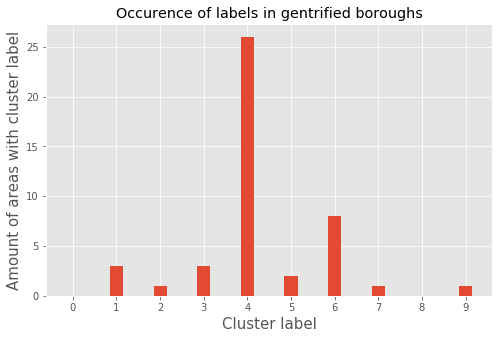

In [59]:
# Plot the frequency of the labels in gentrified boroughs
plt.figure(figsize=(8,5))
plt.bar(clusters[:, 0], clusters[:, 1], width=0.3)
plt.xticks(clusters[:, 0])
plt.title('Occurence of labels in gentrified boroughs')
plt.ylabel('Amount of areas with cluster label', fontsize=15)
plt.xlabel('Cluster label', fontsize=15)

plt.show()

In [60]:
# Find the label for the most occurring value
for label, amounts in cluster_dict.items():
    if amounts == max(clusters[:, 1]):
        most_occurring_label = label

In [61]:
# Make dataframe of ungentrified boroughs for label that occurs most in the gentrified boroughs
gent_prone = london_merged_complete_ungent.loc[london_merged_complete_ungent['Cluster Labels'] == most_occurring_label].reset_index(drop=True)

### Real estate price

In [62]:
# Update the json one last time with all the boroughs that are left in the gent_prone dataframe
gent_prone_uniques = gent_prone['Borough'].unique()
london_json_ungent_real_estate = copy.deepcopy(london_json_ungent)
diff = len(london_json_ungent_real_estate['features']) - len(gent_prone['Borough'].unique())
count = 0

for i in range(len(london_json_ungent_real_estate['features'])-diff):
    if london_json_ungent_real_estate['features'][count]['properties']['name'] not in gent_prone_uniques:
        print(london_json_ungent_real_estate['features'][count]['properties']['name'])
        del london_json_ungent_real_estate['features'][count]
        count -= 1
    count += 1

Kingston upon Thames
Croydon


In [63]:
len(london_json_ungent_real_estate['features'])

21

In [64]:
choropleth_map1 = folium.Map(location=[latitude, longitude], zoom_start=10)

choropleth_map1.choropleth(
    geo_data=london_json_ungent_real_estate,
    data=gent_prone,
    columns=['Borough', 'Price per m2'],
    key_on='feature.properties.name',
    fill_color='PuRd', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Price per square meter'
)

choropleth_map1

C:\Users\Tim\Anaconda3\envs\deeplearning\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Predict borough prone to gentrification

In [65]:
choropleth_map2 = folium.Map(location=[latitude, longitude], zoom_start=10)

choropleth_map2.choropleth(
    geo_data=london_json_ungent_real_estate,
    data=gent_prone,
    columns=['Borough', 'Price per m2'],
    key_on='feature.properties.name',
    fill_color='PuRd', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Price per square meter'
)

for lat, lng, borough, neighborhood in zip(gent_prone['Latitude'], gent_prone['Longitude'], gent_prone['Borough'], gent_prone['Area']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#a60000',
        fill=True,
        fill_color='#a60000',
        fill_opacity=0.5,
        parse_html=False).add_to(choropleth_map2)  

choropleth_map2